In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
from bs4 import BeautifulSoup

In [77]:
netflix = pd.read_csv("C:/Users/kencl/UCDProject/netflixData.csv", index_col =1)

In [78]:
print(netflix.head())

                                                            Show Id  \
Title                                                                 
(Un)Well                       cc1b6ed9-cf9e-4057-8303-34577fb54477   
#Alive                         e2ef4e91-fb25-42ab-b485-be8e3b23dedb   
#AnneFrank - Parallel Stories  b01b73b7-81f6-47a7-86d8-acb63080d525   
#blackAF                       b6611af0-f53c-4a08-9ffa-9716dc57eb9c   
#cats_the_mewvie               7f2d4170-bab8-4d75-adc2-197f7124c070   

                                                                     Description  \
Title                                                                              
(Un)Well                       This docuseries takes a deep dive into the luc...   
#Alive                         As a grisly virus rampages a city, a lone man ...   
#AnneFrank - Parallel Stories  Through her diary, Anne Frank's story is retol...   
#blackAF                       Kenya Barris and his family navigate relations...  

In [79]:
print(netflix.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5967 entries, (Un)Well to 최강전사 미니특공대 : 영웅의 탄생
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Show Id             5967 non-null   object 
 1   Description         5967 non-null   object 
 2   Director            3903 non-null   object 
 3   Genres              5967 non-null   object 
 4   Cast                5437 non-null   object 
 5   Production Country  5408 non-null   object 
 6   Release Date        5964 non-null   float64
 7   Rating              5963 non-null   object 
 8   Duration            5964 non-null   object 
 9   Imdb Score          5359 non-null   object 
 10  Content Type        5967 non-null   object 
 11  Date Added          4632 non-null   object 
dtypes: float64(1), object(11)
memory usage: 606.0+ KB
None


In [80]:
netflix.isnull().sum()

Show Id                  0
Description              0
Director              2064
Genres                   0
Cast                   530
Production Country     559
Release Date             3
Rating                   4
Duration                 3
Imdb Score             608
Content Type             0
Date Added            1335
dtype: int64

As there is a lot of null values in multiple columns, instead of dropping null values and losing a good chunk of the dataset i decided to fill most of the missing values, and drop where i am not losing much.

In [81]:
netflix["Director"] = netflix["Director"].fillna("unknown")

In [82]:
netflix["Cast"] = netflix["Cast"].fillna("unknown")

In [83]:
netflix["Rating"].value_counts()

TV-MA    2541
TV-14    1551
TV-PG     527
R         385
TV-Y      240
PG-13     226
TV-Y7     206
TV-G      146
PG        125
G          15
NC-17       1
Name: Rating, dtype: int64

giving that TV-MA shows up the most often i decided to replace null values in this category with TV-MA

In [84]:
netflix["Rating"] = netflix["Rating"].fillna("TV-MA")

In [85]:
netflix.isna().sum()

Show Id                  0
Description              0
Director                 0
Genres                   0
Cast                     0
Production Country     559
Release Date             3
Rating                   0
Duration                 3
Imdb Score             608
Content Type             0
Date Added            1335
dtype: int64

I am not going to be using date added and i am not losing as much values in the remaining null values so i have decided to drop the rest

In [86]:
netflix = netflix.drop("Date Added", axis=1)

In [87]:
netflix = netflix.dropna(subset=["Production Country", "Release Date", "Duration", "Imdb Score"])

In [88]:
netflix.isnull().sum()

Show Id               0
Description           0
Director              0
Genres                0
Cast                  0
Production Country    0
Release Date          0
Rating                0
Duration              0
Imdb Score            0
Content Type          0
dtype: int64

<AxesSubplot:title={'center':'Content Type on Netflix'}, ylabel='Content Type'>

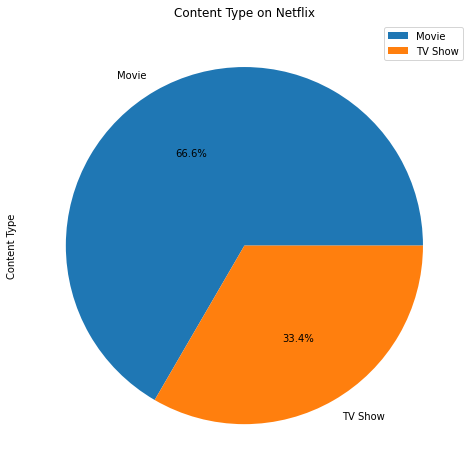

In [89]:
#getting the distribution of movies and shows on netflix
netflix["Content Type"].value_counts().plot(kind="pie", legend=True, title="Content Type on Netflix", autopct='%1.1f%%', figsize=(8,20))

Netflix are producing twice the amount of movie's as they are TV show's

<AxesSubplot:xlabel='Rating', ylabel="number of Movie's and TV Shows">

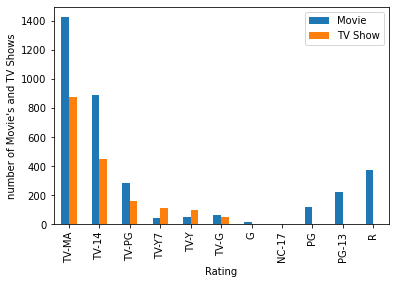

In [90]:
#getting the number of movies/shows per rating by grouping and counting the amount of content in each rating
rating = netflix.groupby(["Content Type", "Rating"])["Rating"].count().unstack("Content Type")
rating.columns = ["Movie", "TV Show"]
rating["Totals"] = rating["Movie"] + rating["TV Show"]
rating = rating.sort_values(ascending=False, by="Totals")
rating.plot(kind="bar", y=["Movie", "TV Show"], ylabel="number of Movie's and TV Shows")

Netflix produce far more movies and tv shows for mature audiences than any other age demographic

<ipython-input-147-df3cf3775fea>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topgenres.index, rotation=90)


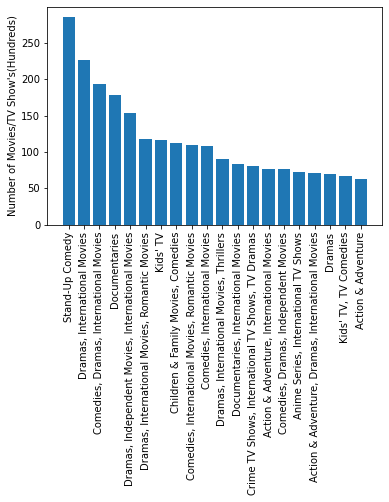

In [147]:
#getting the top genres produced by netflix by getting the most occuring
top_genres = netflix["Genres"].value_counts()

df_topgenres = pd.DataFrame(top_genres[:20], columns= ["Genres", "Genre count"])

fig, ax = plt.subplots()
ax.bar(df_topgenres.index, df_topgenres["Genres"])
ax.set_xticklabels(df_topgenres.index, rotation=90)
ax.set_ylabel("Number of Movies/TV Show's(Hundreds)")
plt.show()

The most frequent genres netflix are producing

In [139]:
url = 'https://www.bloomberg.com/news/articles/2021-10-17/squid-game-season-2-series-worth-900-million-to-netflix-so-far'
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    'referrer': 'https://google.com',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
    'Pragma': 'no-cache'}

#function for extracting html and soupifying the html
def getdata(url): 
    r = requests.get(url, headers=headers) 
    html_doc = r.text 
    soup = BeautifulSoup(html_doc, "html.parser")
    return soup

squid_title = soup.title
print(squid_title)

#looping through paragraphs to concise output
data = ""
for data in soup.find_all("p"): 
    print(data.get_text()) 

<title>Squid Game Season 2? Series Worth $900 Million to Netflix So Far - Bloomberg</title>
More than 130 million people have watched the Korean show
Netflix estimates that its latest megahit,  “Squid Game,” will create almost $900 million in value for the company, according to figures seen by Bloomberg, underscoring the windfall that one megahit can generate in the streaming era.
Netflix differs from movie studios and TV networks in that it doesn’t generate sales based on specific titles, instead using its catalog and a steady drumbeat of new releases to entice customers every week. But the company does have a wealth of data concerning what its customers watch, which the company uses to determine the value derived from individual programs.


Squid game - netflix's newest megahit - is set to earn the company 900 million usd with more than 130 people having watched the show in it's opening weeks.